In [14]:
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaEmbeddings
from sqlalchemy.dialects.oracle import dictionary

embeddings = OllamaEmbeddings(model="qwen2.5-coder:3b")

vector_store = Chroma(
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
    embedding_function=embeddings,
)

retriever = vector_store.as_retriever(search_kwargs={'k': 10})

In [15]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query : str
    context : List[Document]
    answer : str

graph_builder = StateGraph(AgentState)

In [16]:
def retrieve(state: AgentState) :
    query = state['query']
    docs = retriever.invoke(query)
    return {'context' : docs}

In [17]:
from langsmith import Client
from langchain_ollama import ChatOllama

client = Client()
llm = ChatOllama(model="qwen2.5:14b")

In [18]:
generate_prompt = client.pull_prompt("rlm/rag-prompt")

In [19]:
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question' : query, 'context' : context})
    return {'answer' : response}

In [20]:
from typing import Literal

doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance")

def check_doc_relevance(state : AgentState) -> Literal['generate', 'rewrite'] :
    query = state['query']
    context = state['context']
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question' : query, 'documents' : context})

    print(response)

    if response['Score'] == 1:
        return 'generate'

    return 'rewrite'

In [21]:
query = '연봉 5천만원 직장인의 소득세를 한국어로 답해줘'

In [22]:
from langchain_core.prompts import PromptTemplate

dictionary = ['사람을 나타내는 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전 : {dictionary}
질문 : {{query}}
""")

def rewrite(state : AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query' : query})
    return {'rewritten_query': response}

In [23]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [24]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

graph = graph_builder.compile()

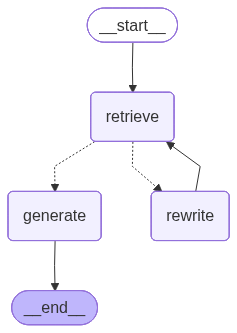

In [25]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
initial_state = {'query' : '연봉 5천만원 세금'}
responses = graph.invoke(initial_state)

InvalidArgumentError: Collection expecting embedding with dimension of 5120, got 2048

In [ ]:
print(responses)